## **Notebook #12**
## Comparing binary classifiers.
**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Caio Francisco Garcia de Lima **RA** 195210


##**Which model architecture is going to best fit my data?**
#### The answer is to test several candidate learning models and verify their performance using a set of alternative criteria, including computational time.
####Warning #1: We are not going to fine-tune and optimize the hyperparameters of the learning models. All models will be run using default hyperparameters.
####Warning #2: We are not going to select the best features among the available inputs. The preprocessing stage is restricted to data partition.
##Based on [this material](https://medium.com/p/a98477476f0).
##The sonar dataset is available [here](https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)) and is also provided with the code.

**Verifique o que ocorre com o ordenamento dos 7 classificadores, quando se varia a porcentagem de dados reservados para teste. Na versão fornecida pelo professor, esse valor está em 40%. Tente 15% e 30%. Procure explicar a variabilidade nos resultados.**

## 15%

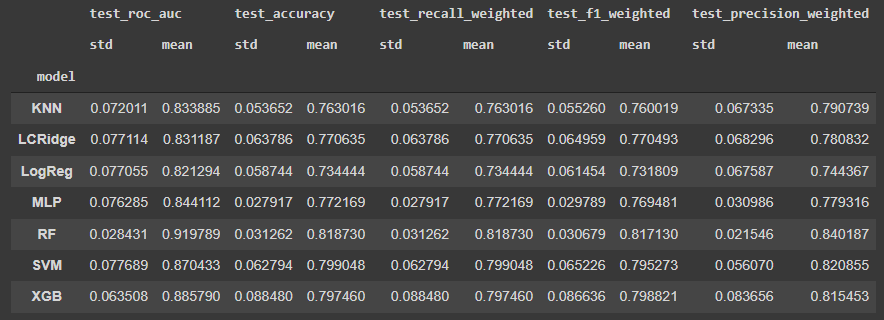

## 30%
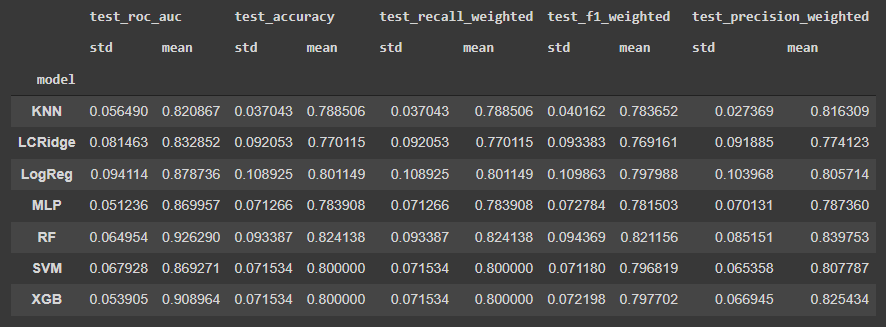

## 40%
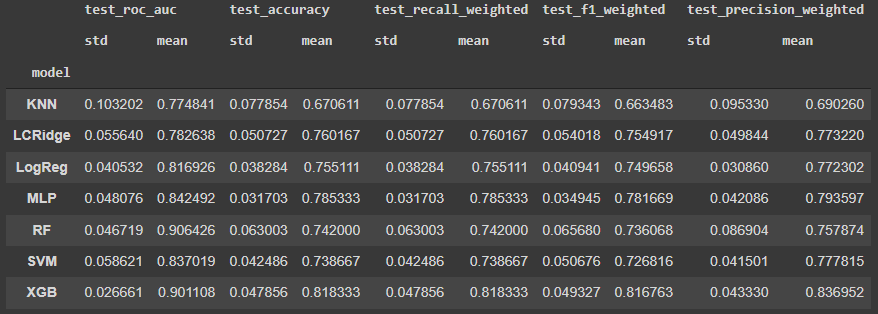

|No|                 15%  |                30%  |                 40% |
|--|----------------------|---------------------|---------------------|
|1 | Random Forest(0.81)  | RandomForest(0.82)  | XGBoost(0.81)       |
|2 | SVM(0.79)            | LogRegression(0.80) | MLP(0.78)           |
|3 | XGBoost(0.79)        | XGBoost(0.80)       | LCRidge(0.76)       |
|4 | MLP(0.77)            | SVM(0.80)           | LogRegression(0.75) |
|5 | LCRidge(0.77)        | KNN(0.78)           | Random Forest(0.74) |
|6 | KNN(0.76)            | MLP(0.78)           | SVM(0.73)           |
|7 | LogRegression(0.73)  | LCRidge(0.77)       | KNN(0.67)           |

</br>

Utilizando o test_accuracy como métrica podemos observar que houve alguma variações no desempenho dos algorítmos conforme a reserva de dados para treinamento, em geral o RandomForest se saiu melhor quando os dados para treinamento eram menores que <b>40%</b>. Porém, como citado no enunciado, nosso dataset é pequeno então provavelmente obtemos resultados não confiáveis, pois os dados não são suficientes para o nosso modelo aprender a mapear as entradas e saídas. Os resultados variaram tanto poossivelmente por conta da insuficiência dos dados somado ao fato de não trabalhamos com seleção de variáveis ou melhoria dos hiperparâmetros, o que poderia auxiliar na melhoria dos modelos para melhor se adequarem aos dados fornecidos.


**O que ocorre com o desempenho da máquina de vetores-suporte? Procure explicar essa variação no desempenho, fundamentado no papel exercido pelo hiperparâmetro C.**



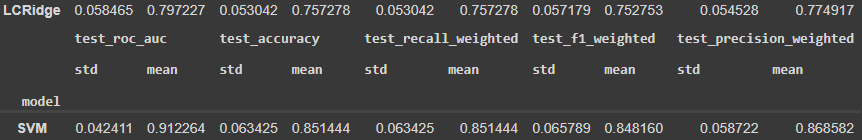

Podemos observar que somente com a alteração do parâmetro C=1000, obtemos resultados muito melhores (0.73 → 0.85)¹, ultrapassando todos os outros modelos.

<small>**Observação¹** Considerando o test_accuracy como métrica.</small>

O valor de C define a margem do hiperplano, quanto mais alto o valor de C menor a margem do hiperplano, com as SVM buscamos um hiperplano com a largura mínima de margem e um hiperplano que separa bem os dados, porém atingir esse objetivo não é tão simples. A imagem a seguir nos mostra as diferenças entre altos valores de C e baixo valores de C.

<center>
<img src="https://camo.githubusercontent.com/24f336f8c82ed85fa34565f6405dc1fed262137ad566be71c39a5b32cf5986eb/687474703a2f2f692e737461636b2e696d6775722e636f6d2f47625735532e706e67" width="500">
</center>

Para definir qual valor de C é mais adequado dependemos de como os dados a serem preditos se parecem, caso seja conforme a imagem a seguir, valores altos de C são mais adequados.
<center>
<img src="https://i.stack.imgur.com/07jiy.png" width="500">
</center>

Porém se nossos dados se parecem mais com estes, um valor de C mais baixo é mais adequado.
<center>
<img src="https://i.stack.imgur.com/jfJ9G.png" width="500">
</center>


In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
# Defining a case study: binary classification problem
from sklearn.preprocessing import LabelEncoder
from pandas import read_csv

drive_path = "/content/drive/MyDrive/Colab Notebooks/PC2_code_data/"
dataframe = read_csv(drive_path + "sonar.csv", header=None)
dataset = dataframe.values
# split into input (X) and output (Y) variables
X = dataset[:,0:60].astype(float)
yy = dataset[:,60]
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(yy)
y = encoder.transform(yy)

In [71]:
print(dataset)

[[0.02 0.0371 0.0428 ... 0.009 0.0032 'R']
 [0.0453 0.0523 0.0843 ... 0.0052 0.0044 'R']
 [0.0262 0.0582 0.1099 ... 0.0095 0.0078 'R']
 ...
 [0.0522 0.0437 0.018 ... 0.0077 0.0031 'M']
 [0.0303 0.0353 0.049 ... 0.0036 0.0048 'M']
 [0.026 0.0363 0.0136 ... 0.0061 0.0115 'M']]


In [72]:
print(X.shape)

(208, 60)


In [73]:
# Splittng the data into [training / validation] and [testing] (60% x 40%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=8675309)

In [78]:
# We are going to consider 7 distinct classifiers and 5-fold crossvalidation
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''  
    dfs = []
    models = [
          ('LCRidge', RidgeClassifier()),
          ('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC(C=1000)), 
          ('MLP', MLPClassifier()),
          ('XGB', XGBClassifier())
        ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['malignant', 'benign']
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
    return final

In [79]:
import warnings
warnings.filterwarnings("ignore")

final = run_exps(X_train, y_train, X_test, y_test)

LCRidge
              precision    recall  f1-score   support

   malignant       0.78      0.85      0.81        41
      benign       0.85      0.77      0.80        43

    accuracy                           0.81        84
   macro avg       0.81      0.81      0.81        84
weighted avg       0.81      0.81      0.81        84

LogReg
              precision    recall  f1-score   support

   malignant       0.73      0.88      0.80        41
      benign       0.86      0.70      0.77        43

    accuracy                           0.79        84
   macro avg       0.80      0.79      0.78        84
weighted avg       0.80      0.79      0.78        84

RF
              precision    recall  f1-score   support

   malignant       0.74      0.98      0.84        41
      benign       0.97      0.67      0.79        43

    accuracy                           0.82        84
   macro avg       0.85      0.83      0.82        84
weighted avg       0.86      0.82      0.82        84

K

####To obtain better estimates of the distribution of metrics from each model, empirical bootstrapping at 30 samples was considered.
#### Notice that the results are of two sorts: performance metrics and fit-time metrics.

In [80]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

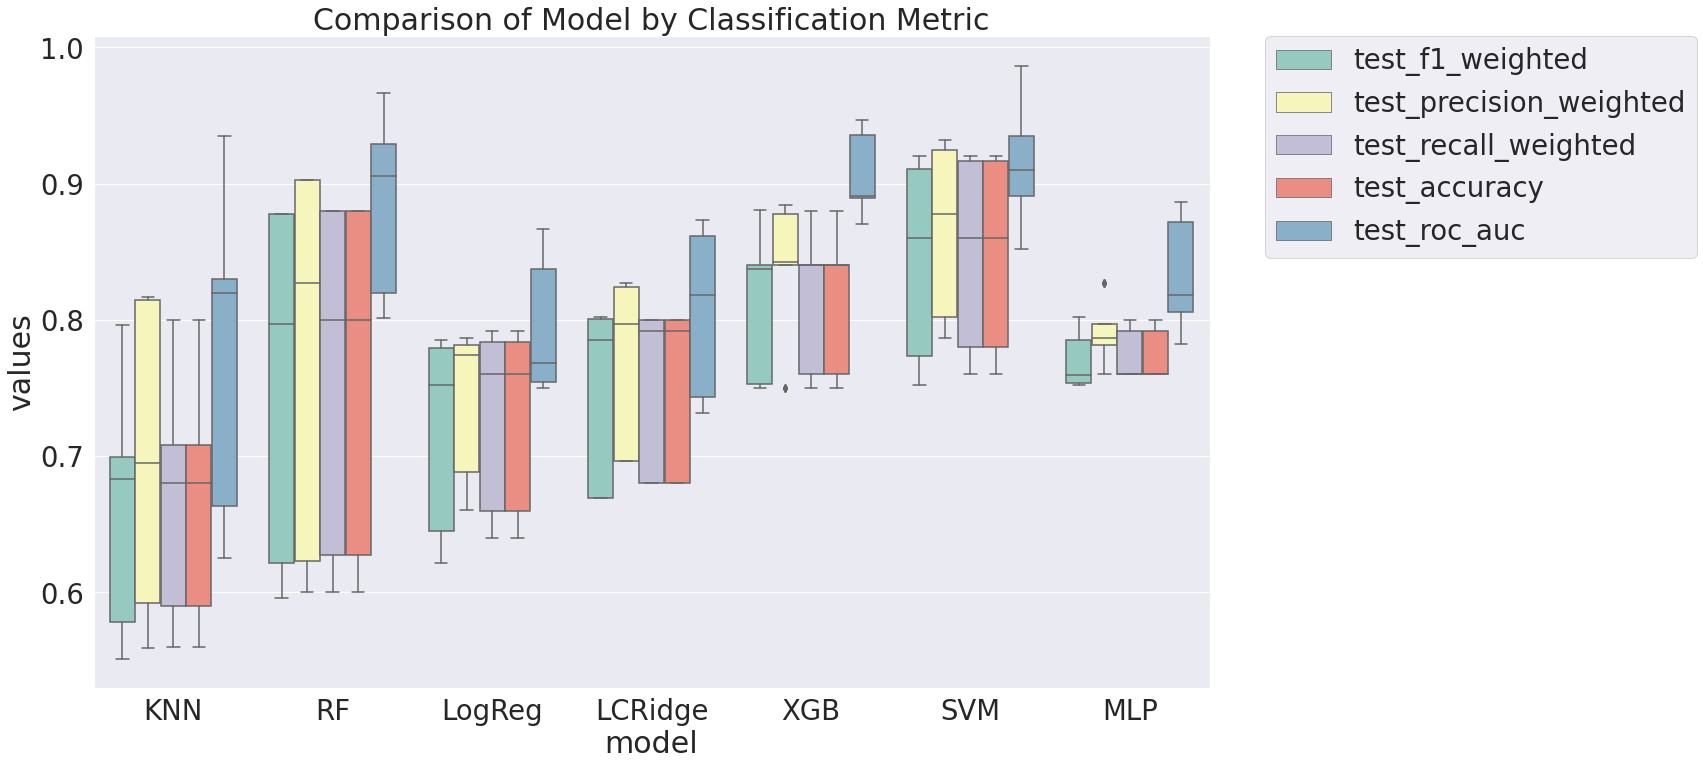

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('benchmark_models_performance.png',dpi=300)

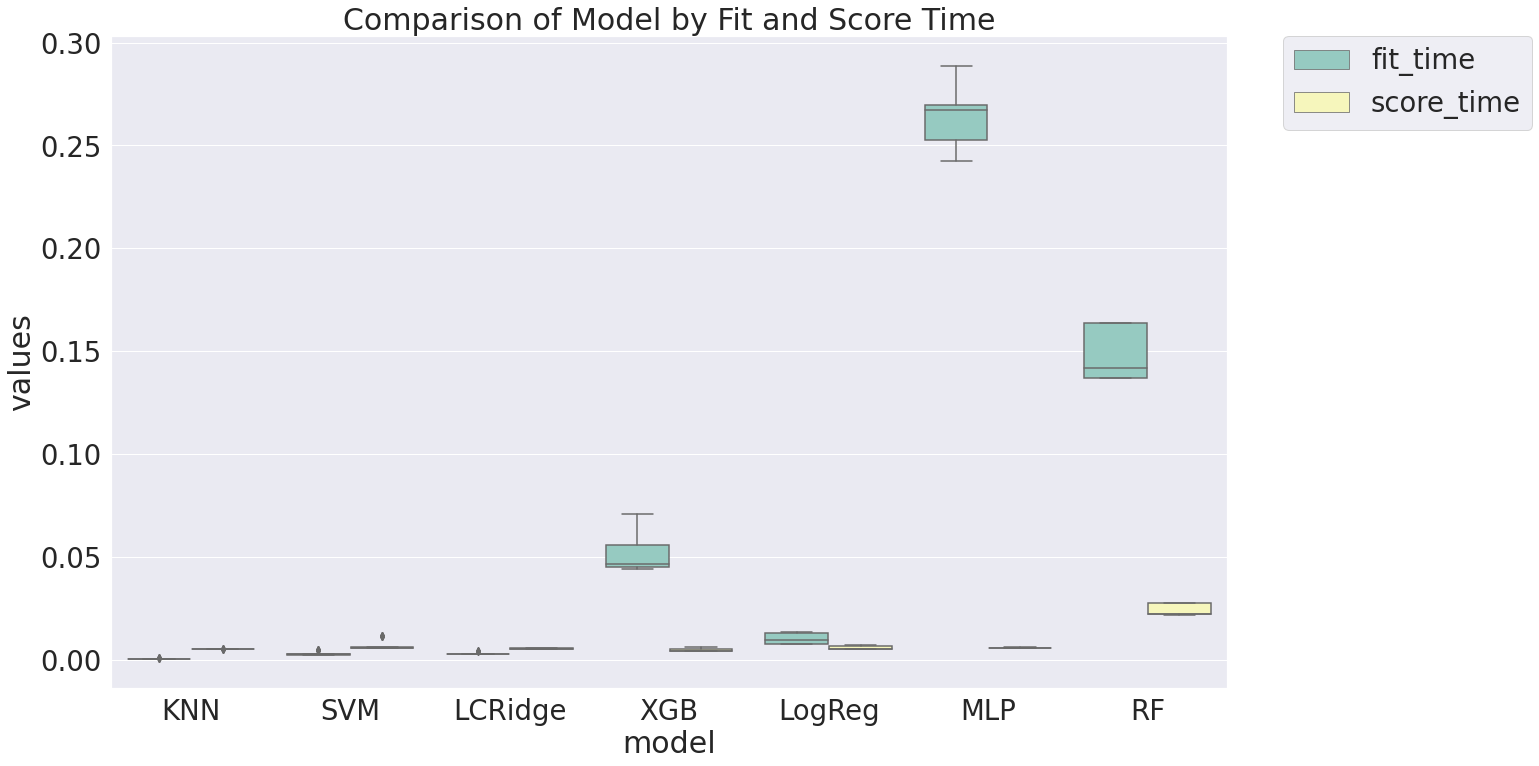

In [82]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
plt.savefig('./benchmark_models_time.png',dpi=300)

In [83]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_roc_auc           test_accuracy           test_recall_weighted  \
                 std      mean           std      mean                  std   
model                                                                         
KNN         0.104689  0.781145      0.083709  0.674833             0.083709   
LCRidge     0.058465  0.797227      0.053042  0.757278             0.053042   
LogReg      0.045800  0.799607      0.059582  0.728444             0.059582   
MLP         0.039806  0.838470      0.017743  0.772222             0.017743   
RF          0.061078  0.892107      0.111160  0.761500             0.111160   
SVM         0.042411  0.912264      0.063425  0.851444             0.063425   
XGB         0.027893  0.904099      0.047856  0.818333             0.047856   

                  test_f1_weighted           test_precision_weighted            
             mean              std      mean                     std      mean  
model                                                                           
KNN      0.674833         0.085613  0.668892                0.100580  0.698748  
LCRidge  0.757278         0.057179  0.752753                0.054528  0.774917  
LogReg   0.728444         0.065211  0.720468                0.053104  0.746912  
MLP      0.772222         0.019499  0.769229                0.021388  0.792189  
RF       0.761500         0.112356  0.758605                0.126273  0.781531  
SVM      0.851444         0.065789  0.848160                0.058722  0.868582  
XGB      0.818333         0.049172  0.816407                0.044548  0.839461

In [84]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.std, np.mean])

fit_time           score_time          
              std      mean        std      mean
model                                           
KNN      0.000037  0.000462   0.000141  0.004995
LCRidge  0.000522  0.002838   0.000307  0.005311
LogReg   0.002378  0.010062   0.000699  0.005818
MLP      0.014376  0.265197   0.000101  0.005703
RF       0.011511  0.146663   0.002627  0.023690
SVM      0.000909  0.002932   0.002420  0.007059
XGB      0.009760  0.051445   0.000712  0.004625

#Pairwise comparison involving one low-performance and two high-performance classifiers.

KNN Mean Accuracy: 79.9% +/-(0.077)
XGB Mean Accuracy: 84.3% +/-(0.071)
RF Mean Accuracy: 84.3% +/-(0.071)


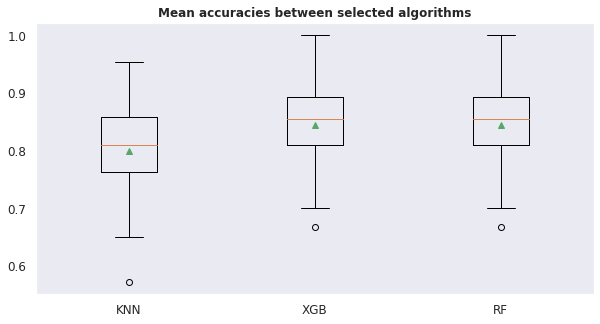

In [85]:
from numpy import mean, std
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from matplotlib.pyplot import figure

plt.figure(figsize = (10, 5))
plt.grid(False)
plt.title("Mean accuracies between selected algorithms", fontsize = 12, fontweight = 'bold')

# Evaluate model 1
model1 = KNeighborsClassifier()
cv1 = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 1)
scores1 = cross_val_score(model1, X, y, scoring = 'accuracy', cv = cv1, n_jobs = -1)
print('KNN Mean Accuracy: %.1f%% +/-(%.3f)' % (mean(scores1*100), std(scores1)))

# Evaluate model 2
model2 = XGBClassifier()
cv2 = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 1)
scores2 = cross_val_score(model2, X, y, scoring = 'accuracy', cv = cv2, n_jobs = -1)
print('XGB Mean Accuracy: %.1f%% +/-(%.3f)' % (mean(scores2*100), std(scores2)))

# Evaluate model 3
model3 = RandomForestClassifier()
cv2 = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 1)
scores3 = cross_val_score(model2, X, y, scoring = 'accuracy', cv = cv2, n_jobs = -1)
print('RF Mean Accuracy: %.1f%% +/-(%.3f)' % (mean(scores3*100), std(scores3)))

# Plot the results
plt.boxplot([scores1, scores2, scores3], labels=['KNN', 'XGB', 'RF'], showmeans=True)
plt.tick_params(labelsize=12)
plt.show()

# The intuition behind the 5X2 fold approach, according to the material [here](https://www.kaggle.com/code/scratchpad/notebook36889cb92e/edit).

One approach is to evaluate each model on the same k-fold cross-validation split of the data (e.g. using the same random number seed to split the data in each case) and calculate a score for each split. This would give a sample of 10 scores for 10-fold cross-validation. The scores can then be compared using a paired statistical hypothesis test because the same treatment (rows of data) was used for each algorithm to come up with each score. The Paired Student’s t-Test could be used.

A problem with using the Paired Student’s t-Test, in this case, is that each evaluation of the model is not independent. This is because the same rows of data are used to train the data multiple times — actually, each time, except for the time a row of data is used in the hold-out test fold. This lack of independence in the evaluation means that the Paired Student’s t-Test is optimistically biased.

This statistical test can be adjusted to take the lack of independence into account. Additionally, the number of folds and repeats of the procedure can be configured to achieve a good sampling of model performance that generalizes well to a wide range of problems and algorithms. Specifically two-fold cross-validation with five repeats, so-called 5×2-fold cross-validation.

This approach was proposed by Thomas Dietterich in his 1998 paper titled “Approximate Statistical Tests for Comparing Supervised Classification Learning Algorithms.”

In [86]:
from mlxtend.evaluate import paired_ttest_5x2cv
# Check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model1, 
                          estimator2=model2, 
                          X=X, 
                          y=y, 
                          scoring='accuracy')
# Summarize
print(f'The P-value is = {p:.3f}')
print(f'The t-statistics is = {t:.3f}')
# Interpret the result
if p <= 0.05:
    print('Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.')
else:
    print('Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different.')

The P-value is = 0.844
The t-statistics is = -0.207
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different.


#### You are welcome to perform the above statistical test several times and realize that the results can vary greatly. Please consider a more in-depth excursion on the subject in [this link](https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/).

In [87]:
# Check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model1, 
                          estimator2=model3, 
                          X=X, 
                          y=y, 
                          scoring='accuracy')
# Summarize
print(f'The P-value is = {p:.3f}')
print(f'The t-statistics is = {t:.3f}')
# Interpret the result
if p <= 0.05:
    print('Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.')
else:
    print('Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different.')

The P-value is = 0.411
The t-statistics is = -0.897
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different.


In [88]:
# Check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model2, 
                          estimator2=model3, 
                          X=X, 
                          y=y, 
                          scoring='accuracy')
# Summarize
print(f'The P-value is = {p:.3f}')
print(f'The t-statistics is = {t:.3f}')
# Interpret the result
if p <= 0.05:
    print('Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different')
else:
    print('Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different.')

The P-value is = 1.000
The t-statistics is = 0.000
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different.
